In [1]:
import sys
from pathlib import Path

In [2]:
root_path = Path.cwd().parent 
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))
root_path

PosixPath('/home/arpola/Documents/GalaxyClassifier')

In [3]:
import mlflow
from mlflow import MlflowClient
import torch
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from src.cnn import NeuralNet
from src.utils.general import get_data, LazyGalaxyDataset,get_splits
import torchmetrics
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2

2026-02-18 18:49:59.070659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
mlflow.set_tracking_uri('http://localhost:5000')

In [5]:
model_metadata = client.get_latest_versions("galaxy-classifier-ecnn")
model_name = model_metadata[0].name
model_version = model_metadata[0].version
print(f"Model name: {model_name}, model version: {model_version}")

Model name: galaxy-classifier-ecnn, model version: 3


/tmp/ipykernel_34297/2205508816.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages


In [6]:
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}") #{model_version}")

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
images_path = root_path / 'data' / 'images_cleaned.npy'
labels_path = root_path / 'data' / 'labels.npy'
symmetry_path = root_path / 'data' / 'assymetries.npy'
test_indices = get_splits(root_path, splits=["test"])['test'] # get_splits returns a dict, thats why it is indexed that way


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_dataset = LazyGalaxyDataset(test_indices, images_path,labels_path,symmetry_path, transform=transform)

paths already exists, breaking


In [8]:
test_loader = DataLoader(test_dataset)

In [9]:
len(test_loader)

3548

In [10]:
# Make prediction for test_dataset[40]
model.eval()
class_names = [
    "0 - Disturbed Galaxies",
    "1 - Merging Galaxies",
    "2 - Round Smooth Galaxies",
    "3 - In-between Round Smooth Galaxies",
    "4 - Cigar Shaped Smooth Galaxies",
    "5 - Barred Spiral Galaxies",
    "6 - Unbarred Tight Spiral Galaxies",
    "7 - Unbarred Loose Spiral Galaxies",
    "8 - Edge-on Galaxies without Bulge",
    "9 - Edge-on Galaxies with Bulge"
]

# Get the 40th sample
sample_image, sample_label,sample_symmetry = test_dataset[40]
# Add batch dimension and move to device
sample_image = sample_image.unsqueeze(0).to(device)  # Shape: (1, 3, 256, 256)
sample_symmetry = sample_symmetry.unsqueeze(0).to(device)
print(sample_image.shape)
# Perform prediction
with torch.no_grad():
    output = model(sample_image,sample_symmetry)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Convert to probabilities
    predicted_class = torch.argmax(probabilities, dim=1).item()  # Get predicted class index

# Print results
print(f"Predicted Class: {class_names[predicted_class]}")
print(f"True Class: {class_names[sample_label]}")
print(f"Probabilities: {probabilities.cpu().numpy()[0]}")

torch.Size([1, 3, 256, 256])
Predicted Class: 0 - Disturbed Galaxies
True Class: 7 - Unbarred Loose Spiral Galaxies
Probabilities: [5.4578823e-01 4.0404405e-02 8.8935435e-02 6.6260225e-04 1.4840639e-05
 4.2852568e-03 1.7966537e-02 2.9923829e-01 8.9076569e-04 1.8135905e-03]



=== RUNNING TARGETED GRAD-CAM ===
Found R2Conv layer: block1.1
Found R2Conv layer: block2.0
Found R2Conv layer: block3.0
Found R2Conv layer: block4.0
Found R2Conv layer: block5.0
Hooking layer: block5.0
Activation hook triggered: features
Final features shape: (100, 64, 64)
Final gradients shape: (100, 64, 64)


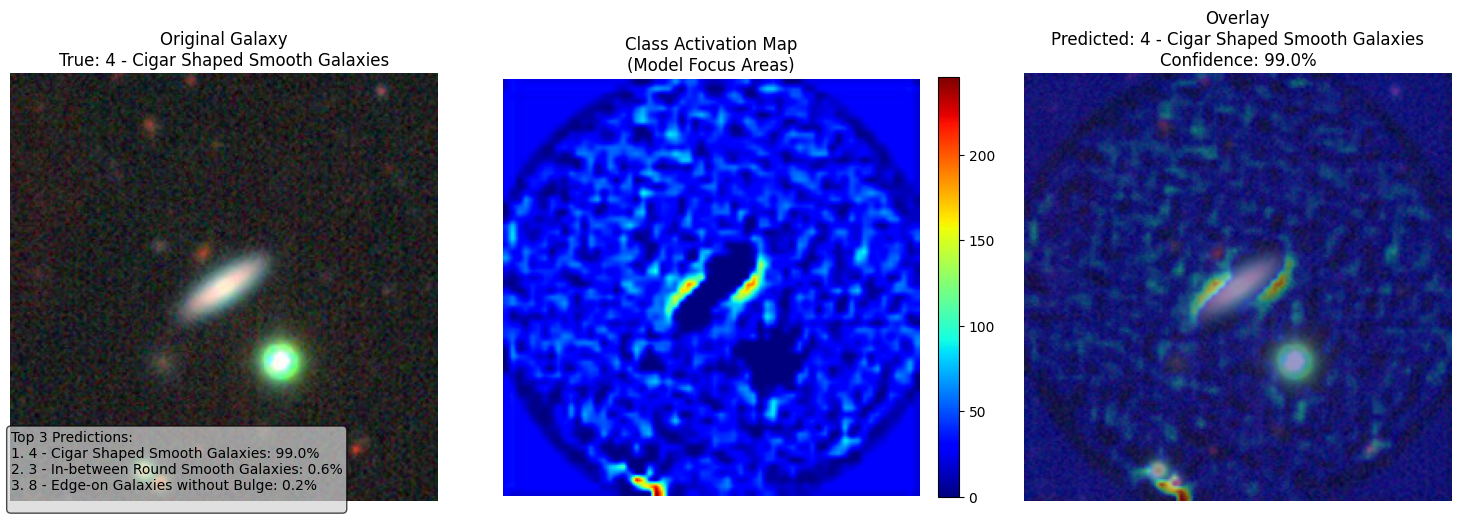

In [25]:
from escnn import nn as enn

def compute_grad_cam_and_predict(model, image, symmetry, target_class, device):
    """
    Computes Grad-CAM for E-CNN model with robust hook placement.
    """
    model.eval()
    
    # Prepare inputs
    image_tensor = image.unsqueeze(0).to(device)
    image_tensor.requires_grad = True
    symmetry_tensor = symmetry.unsqueeze(0).to(device)

    # Storage for hooks
    feature_maps = []
    gradients = []
    hooks = []  # Track all hooks for cleanup

    def hook_features(module, input, output):
        """Hook to capture feature maps."""
        print(f"Feature hook triggered on {type(module).__name__}")
        feature_maps.append(output)

    def hook_gradients(module, grad_input, grad_output):
        """Hook to capture gradients."""
        print(f"Gradient hook triggered on {type(module).__name__}")
        if grad_output[0] is not None:
            gradients.append(grad_output[0])

    # First, let's examine the model structure
    print("Model structure:")
    for name, module in model.named_children():
        print(f"  - {name}: {type(module).__name__}")
        if name == 'block5':
            print(f"    Block5 contents:")
            for subname, submodule in module.named_children():
                print(f"      - {subname}: {type(submodule).__name__}")

    # Try multiple hook locations to ensure we catch something
    hook_targets = []
    
    # Try to hook block5's R2Conv layer specifically
    try:
        if hasattr(model, 'block5'):
            for name, module in model.block5.named_modules():
                if 'R2Conv' in type(module).__name__:
                    print(f"Found R2Conv in block5: {name}")
                    hook_targets.append(('block5_r2conv', module))
                    break
            
            # Also try the whole block5 as fallback
            hook_targets.append(('block5_full', model.block5))
            
        # Try block4 as additional fallback
        if hasattr(model, 'block4'):
            hook_targets.append(('block4_full', model.block4))
            
    except Exception as e:
        print(f"Error finding hook targets: {e}")

    if not hook_targets:
        print("No suitable hook targets found")
        return None, None, None

    # Register hooks on all targets
    for name, target_layer in hook_targets:
        try:
            h1 = target_layer.register_forward_hook(hook_features)
            h2 = target_layer.register_full_backward_hook(hook_gradients)
            hooks.extend([h1, h2])
            print(f"Successfully hooked {name}")
        except Exception as e:
            print(f"Failed to hook {name}: {e}")

    try:
        # Forward pass
        print("Starting forward pass...")
        output = model(image_tensor, symmetry_tensor)
        print(f"Forward pass complete. Output shape: {output.shape}")
        
        # Check target class validity
        if target_class >= output.shape[1]:
            print(f"Error: target_class {target_class} >= num_classes {output.shape[1]}")
            return None, None, None
            
        target_score = output[0][target_class]
        print(f"Target score for class {target_class}: {target_score.item()}")

        # Backward pass
        print("Starting backward pass...")
        model.zero_grad()
        target_score.backward()
        print("Backward pass complete")

        # Clean up hooks
        for hook in hooks:
            try:
                hook.remove()
            except:
                pass

        # Debug: Print what we captured
        print(f"Captured {len(feature_maps)} feature maps")
        print(f"Captured {len(gradients)} gradients")

        if not feature_maps or not gradients:
            print("Error: No feature maps or gradients captured")
            print("This might be due to E-CNN module structure. Trying alternative approach...")
            return compute_grad_cam_alternative(model, image_tensor, symmetry_tensor, target_class, device)

        # Use the last captured feature map and gradient
        features_output = feature_maps[-1]
        gradients_output = gradients[-1]

        # Handle GeometricTensor extraction
        if hasattr(features_output, 'tensor'):
            features_tensor = features_output.tensor.squeeze(0)
        else:
            features_tensor = features_output.squeeze(0)
            
        if hasattr(gradients_output, 'tensor'):
            gradients_tensor = gradients_output.tensor.squeeze(0)
        else:
            gradients_tensor = gradients_output.squeeze(0)
        
        # Move to CPU and convert to numpy
        features_np = features_tensor.cpu().detach().numpy()
        gradients_np = gradients_tensor.cpu().detach().numpy()
        
        print(f"Features shape: {features_np.shape}")
        print(f"Gradients shape: {gradients_np.shape}")

        # Compute Grad-CAM
        weights = np.mean(gradients_np, axis=(1, 2))
        grad_cam = np.zeros(features_np.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam += w * features_np[i, :, :]

        grad_cam = np.maximum(grad_cam, 0)
        if grad_cam.max() > 0:
            grad_cam = grad_cam / grad_cam.max()

        # Resize to input image size
        original_size = (image.shape[2], image.shape[1])
        grad_cam_resized = cv2.resize(grad_cam, original_size, interpolation=cv2.INTER_LINEAR)
        grad_cam_uint8 = np.uint8(255 * grad_cam_resized)

        # Get predictions
        with torch.no_grad():
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()

        return grad_cam_uint8, predicted_class, probabilities.cpu().numpy()[0]

    except Exception as e:
        print(f"Error during Grad-CAM computation: {e}")
        import traceback
        traceback.print_exc()
        
        # Clean up hooks
        for hook in hooks:
            try:
                hook.remove()
            except:
                pass
        return None, None, None


def compute_grad_cam_alternative(model, image_tensor, symmetry_tensor, target_class, device):
    """
    Alternative Grad-CAM approach using gradient computation on intermediate activations.
    """
    print("Trying alternative Grad-CAM approach...")
    
    def forward_hook(module, input, output):
        """Modified forward pass to capture activations."""
        activations['features'] = output
        
    activations = {}
    
    # Try to hook the R2Conv layer inside block5
    hook_handle = None
    try:
        for name, module in model.named_modules():
            if 'block5' in name and 'R2Conv' in type(module).__name__:
                print(f"Hooking alternative target: {name}")
                hook_handle = module.register_forward_hook(forward_hook)
                break
    except:
        pass
    
    if hook_handle is None:
        print("Could not find suitable alternative hook target")
        return None, None, None
    
    try:
        # Forward pass
        output = model(image_tensor, symmetry_tensor)
        target_score = output[0][target_class]
        
        # Compute gradients with respect to activations
        if 'features' in activations:
            features = activations['features']
            if hasattr(features, 'tensor'):
                features_tensor = features.tensor
            else:
                features_tensor = features
                
            # Compute gradients
            grads = torch.autograd.grad(target_score, features_tensor, create_graph=False)[0]
            
            # Process for Grad-CAM
            features_np = features_tensor.squeeze(0).cpu().detach().numpy()
            gradients_np = grads.squeeze(0).cpu().detach().numpy()
            
            weights = np.mean(gradients_np, axis=(1, 2))
            grad_cam = np.zeros(features_np.shape[1:], dtype=np.float32)
            for i, w in enumerate(weights):
                grad_cam += w * features_np[i, :, :]
            
            grad_cam = np.maximum(grad_cam, 0)
            if grad_cam.max() > 0:
                grad_cam = grad_cam / grad_cam.max()
            
            # Resize and return
            original_size = (image_tensor.shape[3], image_tensor.shape[2])
            grad_cam_resized = cv2.resize(grad_cam, original_size, interpolation=cv2.INTER_LINEAR)
            grad_cam_uint8 = np.uint8(255 * grad_cam_resized)
            
            with torch.no_grad():
                probabilities = F.softmax(output, dim=1)
                predicted_class = torch.argmax(probabilities, dim=1).item()
            
            hook_handle.remove()
            return grad_cam_uint8, predicted_class, probabilities.cpu().numpy()[0]
        
    except Exception as e:
        print(f"Alternative approach failed: {e}")
    
    finally:
        if hook_handle:
            hook_handle.remove()
    
    return None, None, None


def compute_grad_cam_regular_cnn(model, image, symmetry, target_class, device):
    """
    Grad-CAM for regular CNN (NeuralNet3).
    """
    model.eval()
    
    image_tensor = image.unsqueeze(0).to(device)
    image_tensor.requires_grad = True
    symmetry_tensor = symmetry.unsqueeze(0).to(device)

    feature_maps = []
    gradients = []

    def hook_features(module, input, output):
        feature_maps.append(output)

    def hook_gradients(module, grad_input, grad_output):
        if grad_output[0] is not None:
            gradients.append(grad_output[0])

    # Hook the last conv layer (layer5)
    try:
        target_layer = model.layer5
        handle_features = target_layer.register_forward_hook(hook_features)
        handle_gradients = target_layer.register_full_backward_hook(hook_gradients)
    except AttributeError:
        print("Error: Could not find layer5 in regular CNN")
        return None, None, None

    try:
        # Forward pass
        output = model(image_tensor, symmetry_tensor)
        target_score = output[0][target_class]

        # Backward pass
        model.zero_grad()
        target_score.backward()

        # Clean up hooks
        handle_features.remove()
        handle_gradients.remove()

        if not feature_maps or not gradients:
            return None, None, None

        # Extract data (regular tensors, not GeometricTensors)
        features_np = feature_maps[0].squeeze(0).cpu().detach().numpy()
        gradients_np = gradients[0].squeeze(0).cpu().detach().numpy()

        # Compute weights and Grad-CAM
        weights = np.mean(gradients_np, axis=(1, 2))
        grad_cam = np.zeros(features_np.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam += w * features_np[i, :, :]

        grad_cam = np.maximum(grad_cam, 0)
        if grad_cam.max() > 0:
            grad_cam = grad_cam / grad_cam.max()

        original_size = (image.shape[2], image.shape[1])
        grad_cam_resized = cv2.resize(grad_cam, original_size, interpolation=cv2.INTER_LINEAR)
        grad_cam_uint8 = np.uint8(255 * grad_cam_resized)

        with torch.no_grad():
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()

        return grad_cam_uint8, predicted_class, probabilities.cpu().numpy()[0]

    except Exception as e:
        print(f"Error during regular CNN Grad-CAM: {e}")
        try:
            handle_features.remove()
            handle_gradients.remove()
        except:
            pass
        return None, None, None


def plot_cam(image, cam, true_class, predicted_class, probabilities, class_names, save_name="grad_cam_visualization.png"):
    """
    Enhanced visualization for galaxy classification.
    """
    # Prepare image for display
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # De-normalize (assuming your normalization)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title(f'Original Galaxy\nTrue: {class_names[true_class]}', fontsize=12)
    axes[0].axis('off')
    
    # Grad-CAM heatmap only
    im = axes[1].imshow(cam, cmap='jet')
    axes[1].set_title('Class Activation Map\n(Model Focus Areas)', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Overlay
    axes[2].imshow(image)
    axes[2].imshow(cam, cmap='jet', alpha=0.4)
    confidence = probabilities[predicted_class]
    axes[2].set_title(f'Overlay\nPredicted: {class_names[predicted_class]}\nConfidence: {confidence:.1%}', fontsize=12)
    axes[2].axis('off')
    
    # Add top-3 predictions as text
    top3_indices = np.argsort(probabilities)[-3:][::-1]
    pred_text = "Top 3 Predictions:\n"
    for i, idx in enumerate(top3_indices):
        pred_text += f"{i+1}. {class_names[idx]}: {probabilities[idx]:.1%}\n"
    
    plt.figtext(0.02, 0.02, pred_text, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    plt.savefig(save_name, dpi=150, bbox_inches='tight')
    plt.show()


def analyze_model_predictions(model, test_dataset, device, class_names, num_samples=5):
    """
    Analyze multiple samples with Grad-CAM to understand model behavior.
    """
    model.eval()
    
    # Determine model type
    is_equivariant = hasattr(model, 'r2_act')
    grad_cam_func = compute_grad_cam_and_predict if is_equivariant else compute_grad_cam_regular_cnn
    
    print(f"Using {'E-CNN' if is_equivariant else 'Regular CNN'} Grad-CAM")
    
    for i in range(num_samples):
        print(f"\n--- Sample {i+1} ---")
        
        # Get sample
        sample_image, sample_label, sample_symmetry = test_dataset[i * 50]  # Spread out samples
        
        # Compute Grad-CAM
        grad_cam, predicted_class, probabilities = grad_cam_func(
            model, sample_image, sample_symmetry, sample_label, device
        )
        
        if grad_cam is not None:
            plot_cam(sample_image, grad_cam, sample_label, predicted_class, 
                    probabilities, class_names, save_name=f'grad_cam_sample_{i+1}.png')
            
            # Print analysis
            correct = "✓" if predicted_class == sample_label else "✗"
            print(f"Prediction: {correct} {class_names[predicted_class]} (confidence: {probabilities[predicted_class]:.1%})")
            print(f"True class: {class_names[sample_label]}")
        else:
            print(f"Failed to compute Grad-CAM for sample {i+1}")


# USAGE EXAMPLES AND DEBUGGING:

def debug_model_structure(model):
    """Debug function to examine model structure for hook placement."""
    print("\n=== MODEL STRUCTURE DEBUG ===")
    for name, module in model.named_modules():
        print(f"{name}: {type(module).__name__}")
        
def find_best_hook_layer(model):
    """Find the best layer to hook for Grad-CAM in E-CNN."""
    candidates = []
    
    for name, module in model.named_modules():
        # Look for R2Conv layers specifically
        if 'R2Conv' in type(module).__name__:
            candidates.append((name, module))
            print(f"Found R2Conv layer: {name}")
    
    if candidates:
        # Use the last R2Conv layer (deepest features)
        return candidates[-1]
    else:
        print("No R2Conv layers found!")
        return None, None

def compute_grad_cam_targeted(model, image, symmetry, target_class, device):
    """
    Targeted Grad-CAM that directly hooks the R2Conv layer.
    """
    model.eval()
    
    # Prepare inputs
    image_tensor = image.unsqueeze(0).to(device)
    image_tensor.requires_grad = True
    symmetry_tensor = symmetry.unsqueeze(0).to(device)

    # Find the best layer to hook
    layer_name, target_layer = find_best_hook_layer(model)
    if target_layer is None:
        print("Could not find suitable layer for hooking")
        return None, None, None

    print(f"Hooking layer: {layer_name}")

    # Storage for activations
    activations = {}
    
    def save_activation(name):
        def hook(module, input, output):
            print(f"Activation hook triggered: {name}")
            activations[name] = output
        return hook
    
    # Register hook
    hook_handle = target_layer.register_forward_hook(save_activation('features'))
    
    try:
        # Forward pass
        output = model(image_tensor, symmetry_tensor)
        target_score = output[0][target_class]
        
        # Check if we captured activations
        if 'features' not in activations:
            print("No activations captured - trying group pooling layer...")
            hook_handle.remove()
            
            # Try hooking before group pooling
            hook_handle = model.gpool.register_forward_hook(save_activation('features'))
            
            # Re-run forward pass
            model.zero_grad()
            image_tensor.grad = None
            output = model(image_tensor, symmetry_tensor)
            target_score = output[0][target_class]
        
        if 'features' not in activations:
            print("Still no activations - the model structure might not support standard Grad-CAM")
            return None, None, None
            
        # Get the captured features
        features = activations['features']
        
        # Handle GeometricTensor
        if hasattr(features, 'tensor'):
            features_tensor = features.tensor
        else:
            features_tensor = features
            
        # Ensure we can compute gradients
        if not features_tensor.requires_grad:
            features_tensor.requires_grad_(True)
        
        # Compute gradients
        model.zero_grad()
        grads = torch.autograd.grad(target_score, features_tensor, 
                                  retain_graph=False, create_graph=False)[0]
        
        # Process to numpy
        features_np = features_tensor.squeeze(0).cpu().detach().numpy()
        gradients_np = grads.squeeze(0).cpu().detach().numpy()
        
        print(f"Final features shape: {features_np.shape}")
        print(f"Final gradients shape: {gradients_np.shape}")
        
        # Compute Grad-CAM
        if len(gradients_np.shape) == 3:  # (C, H, W)
            weights = np.mean(gradients_np, axis=(1, 2))
            grad_cam = np.zeros(features_np.shape[1:], dtype=np.float32)
            for i, w in enumerate(weights):
                grad_cam += w * features_np[i, :, :]
        else:
            print(f"Unexpected gradient shape: {gradients_np.shape}")
            return None, None, None

        grad_cam = np.maximum(grad_cam, 0)
        if grad_cam.max() > 0:
            grad_cam = grad_cam / grad_cam.max()

        # Resize to input size
        original_size = (image.shape[2], image.shape[1])
        grad_cam_resized = cv2.resize(grad_cam, original_size, interpolation=cv2.INTER_LINEAR)
        grad_cam_uint8 = np.uint8(255 * grad_cam_resized)

        # Get predictions
        with torch.no_grad():
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()

        return grad_cam_uint8, predicted_class, probabilities.cpu().numpy()[0]
        
    except Exception as e:
        print(f"Error in targeted Grad-CAM: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None
    finally:
        try:
            hook_handle.remove()
        except:
            pass


# For single sample analysis:
sample_image, sample_label, sample_symmetry = test_dataset[101]

# First debug the model structure
#debug_model_structure(model)

# Try the targeted approach
print("\n=== RUNNING TARGETED GRAD-CAM ===")
grad_cam, predicted_class, probabilities = compute_grad_cam_targeted(
    model, sample_image, sample_symmetry, sample_label, device
)

if grad_cam is not None:
    plot_cam(sample_image, grad_cam, sample_label, predicted_class, 
             probabilities, class_names)
else:
    print("Grad-CAM computation failed. This might be due to E-CNN's complex module structure.")
    print("Consider using feature visualization or attention maps instead.")


In [12]:
def conf_matrix_eval(model):
    model.eval()
    metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=10).to(device)

    with torch.no_grad():
        for X_batch, y_batch,sym_batch in test_loader:
            X_batch, y_batch, sym_batch = X_batch.to(device), y_batch.to(device), sym_batch.to(device)
            y_pred_logits = model(X_batch,sym_batch)  # Raw logits [batch_size, 10]

            # Convert logits to predicted class indices
            _, y_pred_classes = torch.max(y_pred_logits, 1)

            metric.update(y_pred_classes, y_batch)  

    conf_matrix = metric.compute()

    # Calculate precision, recall, and F1-score from the confusion matrix
    for i, class_name in enumerate(class_names):
        tp = conf_matrix[i, i].item()
        fp = conf_matrix[:, i].sum().item() - tp
        fn = conf_matrix[i, :].sum().item() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Metrics for {class_name}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1_score:.4f}")
    return conf_matrix

In [13]:
conf_matrix = conf_matrix_eval(model)

Metrics for 0 - Disturbed Galaxies:
  Precision: 0.5172
  Recall: 0.4861
  F1-score: 0.5012
Metrics for 1 - Merging Galaxies:
  Precision: 0.8338
  Recall: 0.8405
  F1-score: 0.8371
Metrics for 2 - Round Smooth Galaxies:
  Precision: 0.8706
  Recall: 0.9414
  F1-score: 0.9046
Metrics for 3 - In-between Round Smooth Galaxies:
  Precision: 0.9353
  Recall: 0.8547
  F1-score: 0.8932
Metrics for 4 - Cigar Shaped Smooth Galaxies:
  Precision: 0.6154
  Recall: 0.8358
  F1-score: 0.7089
Metrics for 5 - Barred Spiral Galaxies:
  Precision: 0.8364
  Recall: 0.8753
  F1-score: 0.8554
Metrics for 6 - Unbarred Tight Spiral Galaxies:
  Precision: 0.7382
  Recall: 0.8087
  F1-score: 0.7718
Metrics for 7 - Unbarred Loose Spiral Galaxies:
  Precision: 0.8137
  Recall: 0.6312
  F1-score: 0.7109
Metrics for 8 - Edge-on Galaxies without Bulge:
  Precision: 0.8712
  Recall: 0.9049
  F1-score: 0.8877
Metrics for 9 - Edge-on Galaxies with Bulge:
  Precision: 0.8744
  Recall: 0.9467
  F1-score: 0.9091


<Axes: >

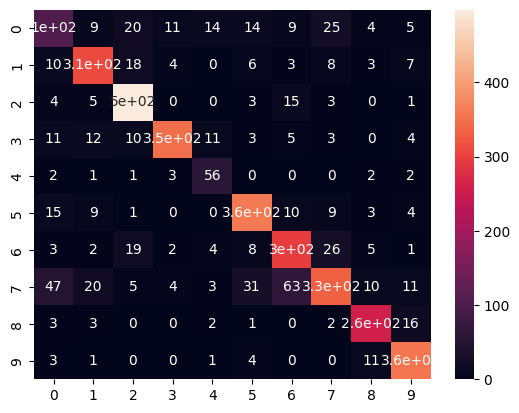

In [14]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
sns.heatmap(conf_matrix.cpu().numpy(),annot=True)